## Prototype 3

Note: this final prototype consists of only the most effective model (RFC), and featureset (Combination). To see the results of comparative testing between models and featuresets, please see Prototype 2

### 1. Preliminary Data Preperation

##### 1.1 Data Import and Cleaning

The data cleaning and data reshape portions will be the same as prototype 2

First, install the neccesary libraries and import modules

In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install textblob
# !pip install nltk

In [1]:
import pandas as pd
import json

Read the input jsonl file to an intermediate dataframe. 

This time, we will read the entire HC3 dataset

In [2]:
# convert jsonl to dataframe
with open('all.jsonl', encoding='utf8') as f:
    # read lines from jsonl into an intermediate df
    lines = f.read().splitlines()
    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']

In [3]:
df_inter.sample(3)

,json_element
18385,"{""question"":""Please explain what is \""Multimod..."
11325,"{""question"":""How can you explain that intellig..."
7848,"{""question"":""Why do we forget our dreams ? I '..."


Next, split the dataframe into its respective columns

In [4]:
#normalise the intermediate dataframe to seperate the data into columns
df = pd.json_normalize(df_inter['json_element'].apply(json.loads))

In [5]:
df.sample(3)

,question,human_answers,chatgpt_answers,index,source
9916,Richard Sherman I keep hearing about this guy ...,[He saved the NFC championship after being goo...,[Richard Sherman is a professional American fo...,NaN,reddit_eli5
21695,What to consider before buying (exercising) a ...,[The company may not permit a transfer of thes...,[There are several things to consider before b...,NaN,finance
14995,What causes wind ? I checked out the Wikipedia...,[Basically heat rises . When air gets hot it e...,[Wind is caused by the movement of air. When t...,NaN,reddit_eli5


Due to formatting issues (this category has a large amount of wikipedia formatting tags that vary greatly in format), we will also drop any rows that belong to the Computer Science Wikipedia Articles category (842 rows).

In [6]:
prev_len = len(df) #find the current length of the dataframe before removal
prev_len

24322

In [7]:
df = df[df.source != 'wiki_csai'] #remove the wiki_csai rows
df.reset_index(inplace=True, drop=True) #also reset the indexes of the dataframe

In [8]:
cur_len = len(df) 
prev_len - cur_len #check to make sure the correct number of rows was removed

842

In [9]:
df.sample(3)

,question,human_answers,chatgpt_answers,index,source
1781,Why does cars need petrol / gas in order to fu...,[They can . Gas is one of the most efficient a...,[Cars need gasoline (also called petrol) to fu...,174.0,reddit_eli5
12741,Why when I press on my skin it leaves a white ...,[You have tiny blood vessels near the surface ...,[Pressing on your skin can cause a temporary c...,NaN,reddit_eli5
10666,"When I open a PC application with notepad , wh...",[Because Notepad is used to reading the 0 's a...,[When you open a PC application with a text ed...,NaN,reddit_eli5


Now that we have removed the wiki_csai category, we can also drop the 'index' and 'source' columns, as they will not be used.

In [10]:
df.drop(['index', 'source'], axis=1, inplace=True) # drop index and source columns

Next, we can inspect the data for missing values.

In [11]:
# find any missing/NA values
df.isna().sum()

question           0
human_answers      0
chatgpt_answers    0
dtype: int64

No missing values were found.

Since each answer is a list, a list containing just empty strings, or an empty list will not be considered by panda's isna() function as a NA value. Thus, we will also inspect the dataframe for empty strings.

Some empty strings were found. Since these empty strings make up an insignificant portion of the dataset (~2%), they can be removed without significantly changing the makeup of the dataset.

In [12]:
#check for empty strings
drop_cntr = 0
for i in range(len(df)):
    human_ans = df.at[i, 'human_answers']
    gpt_ans = df.at[i, 'chatgpt_answers']
    # if the answers are an empty string, or an empty list,
    if '' in human_ans or '' in gpt_ans or len(human_ans) == 0 or len(gpt_ans) == 0:
        #drop the row
        df.drop(i, axis=0, inplace=True)
        drop_cntr += 1
#print drop counter        
print(f'dropped {drop_cntr} rows')

dropped 470 rows


Next, reset the indexes of the dataset without the removed rows (so that it can be iterated over later)

In [13]:
df.reset_index(inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)

We will describe the dataset to inspect the values contained within

In [14]:
df.describe(include='all')

,question,human_answers,chatgpt_answers
count,23010,23010,23010
unique,22482,21508,22447
top,Why we learned to cover our private parts with...,[The attack on Pearl Harbor (called Hawaii Ope...,[!Only one message at a time. Please allow any...
freq,2,3,14


We have also found some duplicate values, including duplicate questions, human answers, and chatgpt answers (which seems to be an error message)

These rows will be removed once the dataframe has been processed further (as it will be easier to remove them after the dataframe is converted to strings)

Next, we will inspect the dataframe's data types

In [16]:
# check datatypes
df.dtypes

question           object
human_answers      object
chatgpt_answers    object
dtype: object

The dataframe will be converted to the string datatype.

In [17]:
#convert to string
df = df.astype(str)

Next, we will need to strip the trailing/leading square brackets from the answers, and remove any newline characters (\n). We will also remove some Reddit text formatting tags and syntaxes.

In [28]:
# define a function to strip formatting from answers
def strip_formatting(answer):
    # strip leading/trailing square brackets and quotation marks
    answer = answer.lstrip('[\'\"') 
    answer = answer.rstrip(']\'\"')
    answer = answer.replace('\\n', "") # remove all newline chars
    answer = answer.replace('\\r', "") # remove all carraige return chars
    answer = answer.replace('*', "") # remove reddit formatting *
    answer = answer.replace('[', "") # remove reddit formatting square brackets
    answer = answer.replace(']', "") # strip other square brackets

    return answer

In [18]:
for i in range(len(df)):
    human_ans = df.at[i, 'human_answers']
    gpt_ans = df.at[i, 'chatgpt_answers']

    df.at[i, 'human_answers'] = strip_formatting(human_ans)
    df.at[i, 'chatgpt_answers'] = strip_formatting(gpt_ans)

In [19]:
df.describe(include='all')

,question,human_answers,chatgpt_answers
count,23010,23010,23010
unique,22482,21508,22445
top,Why we learned to cover our private parts with...,The attack on Pearl Harbor (called Hawaii Oper...,!Only one message at a time. Please allow any ...
freq,2,3,17


Now that the dataframe has been converted to strings, we can easily remove the rows containing the chatgpt error messages

In [20]:
df = df[df['chatgpt_answers'].str.contains('There was an error generating a response') == False]

We will also remove the duplicate questions and answers.

In [21]:
df.drop_duplicates(subset = ['human_answers'], inplace=True)
df.drop_duplicates(subset = ['chatgpt_answers'], inplace=True)
df.drop_duplicates(subset = ['question'], inplace=True)

In [22]:
df.describe(include ='all')

,question,human_answers,chatgpt_answers
count,21398,21398,21398
unique,21398,21398,21398
top,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...
freq,1,1,1


Additionally, the HC3 dataset covers both Chinese and English answers. Though we only imported the English portion of the dataset, it would be advisable to ensure all answers are actually in English.


This check will be carried out using the langdetect python package, which is a Python port of Google's language detection library.

First, install and import langdetect

In [23]:
#!pip install langdetect

In [24]:
from langdetect import detect

Next, define a function to detect if the text is english.

In [25]:
def detect_english(answer):
    # detects if the given answer is in English
    if (detect(answer) == 'en') == False: 
        raise Exception() #detects if the

We will also reset the indexes of the dataframe so we can iterate through it

In [26]:
df.reset_index(inplace=True)

Call the detect_english method on both the human and chatgpt answers to remove any non-English answers. Once again, this makes up an extremely small portion of the entire dataset

In [27]:
drop_cntr = 0 # counter for number of rows dropped
for i in range(0, len(df)):
    # extract human and gpt answers
    human_ans = df.at[i, 'human_answers']
    gpt_ans = df.at[i, 'chatgpt_answers']
    
    try:
        # try to call detect_english on both answers
        detect_english(human_ans)
        detect_english(gpt_ans)
    except:
        # print error message if either answer raises an exception
        print(f'non-english answer at f{i}')
        # drop the row
        df.drop(i, axis=0, inplace=True)
        drop_cntr += 1

# print total rows dropped
print(f'dropped {drop_cntr} rows')

non-english answer at f15520
non-english answer at f15908
non-english answer at f17052
non-english answer at f20613
non-english answer at f20659
non-english answer at f20681
dropped 6 rows


This results in a cleaned dataset that is about 88% the size of the original dataset. In our opinion, the majority of the original dataset is preserved, and the cleaning is unlikely to significantly affect our results.

##### 1.2 Data Reshape

We will also need to reshape the dataframe to seperate human and chatgpt answers into distinct rows.

First, we will seperate the dataframe into 2 seperate dataframes, each containing only 1 type of answer.

We will also add an additional 'is_human' column to each dataframe, indicating if the answer was generated by a human

In [31]:
# retrieve human answers
df_human = df[['question', 'human_answers']].copy() #copy the question and human answers
df_human['is_human'] = 1 #set a column indicating if the answer is human
df_human.rename(columns = {'human_answers':'answer'}, inplace = True) # rename column to answer
df_human.sample(3)

,question,answer,is_human
4410,How does Polysporin work ? It says on the tube...,Polysporin is just antibiotic ointment . There...,1
1012,Postmodernism Please explain what postmodernis...,"It \'s been used a lot in recent history , so ...",1
3107,"The process and significance of "" making partn...",It takes anywhere from 2 to 10 years to make p...,1


In [32]:
# do the same for chatgpt answers
df_gpt = df[['question', 'chatgpt_answers']].copy()
df_gpt['is_human'] = 0
df_gpt.rename(columns = {'chatgpt_answers':'answer'}, inplace = True)
df_gpt.sample(3)

,question,answer,is_human
565,"What exactly causes the feeling of "" pins and ...","The feeling of ""pins and needles"" or tingling ...",0
2775,"will someone please"" dues ex machina "" I do n'...","Deus ex machina is a Latin phrase that means ""...",0
13985,"Reddit , why does America use the A , B , C gr...","The A, B, C grading system is used in America ...",0


Next, both dataframes will be concatenated to join them together into a cleaned dataframe

In [33]:
# concat both dataframes
df_cleaned = pd.concat([df_human, df_gpt])
df_cleaned.sample(3)

,question,answer,is_human
20192,"Suggest remedy for low grade fever, hot and co...",I'm sorry to hear that you're feeling sick. It...,0
17472,What's a Letter of Credit? Are funds held in m...,A letter of credit is a financial instrument t...,0
11418,What happens when a person goes to the hospita...,If a person goes to the hospital because they ...,0


We will also use the panda's value_counts function to ensure that there is the expected number of each type of answer

In [34]:
# sum is_human to ensure there is a 50:50 split of answers
df_cleaned['is_human'].value_counts()

is_human
1    21392
0    21392
Name: count, dtype: int64

Lastly, we will shuffle the order of the answers

In [35]:
# shuffle human and chatgpt generated answers
df_cleaned = df_cleaned.sample(frac = 1).reset_index(drop=True)

In [36]:
df_cleaned.sample(3)

,question,answer,is_human
14089,"How come almost every time I cook eggs , that ...",The film you see on the edges of your cooked e...,0
38818,what do hard drugs do that cause a permanent c...,"For one thing , they rob you of nutrition beca...",1
23538,Suggest alternative medicine for ciplatrimI wa...,I'm sorry to hear that you have been prescribe...,0


##### 1.3 Lemmatisation

We will also create both a lemmatised, and a filtered (both lemmatised, and stopword-removed) version of each answer for later usage in some methods, such as sentiment analysis. 


Compared to stemming, lemmatisation preserves the context and meaning of a word whe converting it to its base form. Preserving the context and meaning of each word will allow for a more accurate sentiment analysis

First, download NLTK packages, and import the required modules.

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Also download NLTK packages
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Next, initialise the lemmatiser, and the corpus of stopwords. The stopword corpus used will be NLTK's general English stopword corpus.

In [41]:
# init lemmatiser and stopwords
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

# also create empty columns for filtered/lemmatised answers
df_cleaned['filtered_answer'] = ""
df_cleaned['lemmatised_answer'] = ""

Next, iterate through each answer, processing each answer by either:

1) just lemmatising the answer, or
2) both removing stopwords and lemmatising the answer.

In [42]:
for i in range(len(df_cleaned)):

    answer = df_cleaned.at[i, 'answer'] #retrieve answer text from df
    tokens = word_tokenize(answer) # tokenise the answer

    # lemmatise answer
    lemmatised_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # reconstruct the answer as a string, and store lemmatised answer in column
    df_cleaned.at[i, 'lemmatised_answer'] = ' '.join(lemmatised_tokens)

    # remove stopwords
    tokens_no_stopwords = [token for token in tokens if token not in stopwords]
    # lemmatise stopword-removed answer
    lemmatised_tokens_no_stopwords = [lemmatizer.lemmatize(token) for token in tokens_no_stopwords]
    
    # reconstruct the answer as a string, and store filtered answer in column
    df_cleaned.at[i, 'filtered_answer'] = ' '.join(lemmatised_tokens_no_stopwords)

In [43]:
df_cleaned.sample(3)

,question,answer,is_human,filtered_answer,lemmatised_answer
4194,""" Floating Point "" Numbers I tried looking at ...","When programming , if you need a number , like...",1,"When programming , need number , like 2 27 -3 ...","When programming , if you need a number , like..."
18832,what do movie directors actually do ? What do ...,Movie directors are responsible for overseeing...,0,Movie director responsible overseeing making f...,Movie director are responsible for overseeing ...
27393,"How can animals like bees "" smell your fear "" ...","Bees can\'t actually ""smell your fear,"" but th...",0,"Bees can\'t actually `` smell fear , '' sense ...","Bees can\'t actually `` smell your fear , '' b..."


### 2. Feature Extraction

As discovered in prototype 2, a combination of all 5 features performs better than any individual feature. Thus, we will extract all 5 features.

##### 2.1 Basic Textual Features

We will extract the word count, sentence count, character count, average word length, and average sentence length.

In [44]:
# import sentence and word tokenisers
from nltk.tokenize import word_tokenize, sent_tokenize 

In [45]:
#initialise columns for the extracted features
df_cleaned['word_count'] = 0
df_cleaned['sentence_count'] = 0
df_cleaned['char_count'] = 0
df_cleaned['avg_sentence_len'] = 0
df_cleaned['avg_word_len'] = 0

Next, iterate through each answer, extracting the selected features.

In [46]:
for i in range(len(df_cleaned)):
    answer = df_cleaned.at[i, 'answer'] # extract answer text from df
    
    ans_sent_token = sent_tokenize(answer)# tokenise answer into sentences
    sentence_count = len(ans_sent_token)# calculate sentence count
    df_cleaned.at[i, 'sentence_count'] = sentence_count

    ans_word_token = word_tokenize(answer) # tokenise answer into words
    word_count = len(ans_word_token)  # calculate word count
    df_cleaned.at[i, 'word_count'] = word_count

    char_count = len(answer) # calculate character count
    df_cleaned.at[i, 'char_count'] =  char_count

    df_cleaned.at[i, 'avg_sentence_len'] = word_count/sentence_count # calculate average sentence length
    df_cleaned.at[i, 'avg_word_len'] =  char_count/word_count   # calculate average word length

In [47]:
df_cleaned.sample(3)

,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,char_count,avg_sentence_len,avg_word_len
37122,"why do wrecking balls , and possibly other wre...",Wrecking balls and other demolition equipment ...,0,Wrecking ball demolition equipment often spray...,Wrecking ball and other demolition equipment o...,164,4,875,41.0,5.335366
36710,"Retired, want to buy a mobile home; how to fin...",There are a few different options for financin...,0,"There different option financing mobile home ,...",There are a few different option for financing...,352,8,1910,44.0,5.426136
35709,Why are flying planes louder when it is cloudy...,Sound travels better through humid air than dr...,1,Sound travel better humid air dry air . This h...,Sound travel better through humid air than dry...,351,15,1807,23.4,5.148148


##### 2.2 Sentiment Analysis

4 metrics will be assessed – negativity, neutrality, subjectivity, and overall polarity. <br><br>

To calculate overall polarity, we will use 2 analysers - NLTK's VADER and TextBlob. This will allow us to obtain a secondary opinion, and provide a more accurate compound score. <br><br>
 
The rest of the metrics will be extracted using only 1 analyser, as each analyser supports a different set of metrics. Negativity and neutrality will be extracted using VADER, and subjectivity will be extracted by Textblob.



First, import the required modules and download the required VADER NLTK package.

In [48]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [49]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

We will also initialise empty columns for the extracted features.

In [50]:
# initialise columns for the extracted features
df_cleaned['polarity'] = 0
df_cleaned['negativity'] = 0
df_cleaned['neutrality'] = 0
df_cleaned['subjectivity'] = 0

Next, initialise the NLTK VADER sentiment analyser (TextBlob does not need to be initialised using a constructor)

In [51]:
analyser = SentimentIntensityAnalyzer()

Next, iterate through each filtered answer (lemmatised + stopwords removed), extracting the negativity (NLTK only), neutrality (NLTK only), polarity (both), and subjectivity (TextBlob only) of each answer.

In [52]:
for i in range(len(df_cleaned)):
    answer = df_cleaned.at[i, 'filtered_answer']
    #analyse filetered answers
    nltk_scores = analyser.polarity_scores(answer)
    textblob_scores = TextBlob(answer).sentiment

    # extract neg and neu using nltk
    df_cleaned.at[i, 'negativity'] = nltk_scores['neg']
    df_cleaned.at[i, 'neutrality'] = nltk_scores['neu']

    # calculate average polarity by using results from both analysers
    df_cleaned.at[i, 'polarity'] = (nltk_scores['compound'] + textblob_scores.polarity)/2

    # extract subjectivity using textblob
    df_cleaned.at[i, 'subjectivity'] = textblob_scores.subjectivity

In [53]:
df_cleaned.sample(3)

,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,char_count,avg_sentence_len,avg_word_len,polarity,negativity,neutrality,subjectivity
8098,Why does the exchange rate between countries f...,Exchange rates fluctuate because they are dete...,0,Exchange rate fluctuate determined supply dema...,Exchange rate fluctuate because they are deter...,251,12,1304,20.916667,5.195219,0.543355,0.1,0.655,0.421905
9426,when was srv born,"Stephen ""Stevie"" Ray Vaughan (October 3, 1954 ...",1,"Stephen `` Stevie '' Ray Vaughan ( October 3 ,...","Stephen `` Stevie '' Ray Vaughan ( October 3 ,...",28,1,131,28.000000,4.678571,0.000000,0.0,1.000,0.000000
24378,Why ca n't we just boil sea water to solve the...,Boiling water takes a ton of energy . Most of ...,1,Boiling water take ton energy . Most time 's f...,Boiling water take a ton of energy . Most of t...,109,7,532,15.571429,4.880734,0.410117,0.0,0.884,0.449524


##### 2.3 Syntactic and Lexical Density

##### 2.3.1 Lexical Density

First, we will extract the lexical density of each answer. This will involve counting the number of lexical terms in each answer (nouns/proper nouns, adjectives, verbs, prepositions, and adverbs), and dividing them by the total number of words in the answer.

First, install and import spaCy, and download the pre-trained en_core_web_sm model, which is optimised for CPU processing.

In [53]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [54]:
import spacy

Also, create an empty column for the lexical density feature

In [55]:
df_cleaned['lexical_density'] = 0 # create an empty column for lexical density

Load the spacy en_core_web_sm model, and a list of POS tags that denote lexical words

In [56]:
nlp = spacy.load("en_core_web_sm") # load spacy model
tags = ['PROPN', 'ADJ', 'NOUN', 'VERB', 'ADP', 'ADV'] # load list of desired lexical word tags

Finally, iterate through every row and count the number of lexical words. Then, divide the number of lexical words by the total word count to calculate the lexical density of each answer.

In [57]:
for i in range(len(df_cleaned)):
    
    answer = df_cleaned.at[i, 'answer'] #extract the answer text
    word_count = df_cleaned.at[i, 'word_count'] #extract word count

    lexical_word_cntr  = 0 #initialise counter for lexical words
    ans_pos = nlp(answer) # analyse answer text using model

    # for each word in the analysed answer
    for token in ans_pos:
        # check if it is a lexical word (POS tag is in the list of desired tags)
        if token.pos_ in tags:
            lexical_word_cntr += 1
    
    df_cleaned.at[i, 'lexical_density'] = lexical_word_cntr/word_count # calculate lexical density

##### 2.3.2 Named Entity Count

Next, we will extract the named entity features. The count of named entities will be extracted using spaCy.

In [58]:
df_cleaned['NE_count'] = 0

In [59]:
for i in range(len(df_cleaned)):
    answer = df_cleaned.at[i, 'answer'] #extract the answer text
    ans_NE = nlp(answer) # analyse answer text using the spaCy model
    df_cleaned['NE_count'] = len(ans_NE.ents) #retrieve the NE count for each answer

In [60]:
df_cleaned.sample(3)

,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,char_count,avg_sentence_len,avg_word_len,polarity,negativity,neutrality,subjectivity,lexical_density,NE_count
25422,Can everyday people profit from unexpected wor...,It is possible for everyday people to profit f...,0,It possible everyday people profit unexpected ...,It is possible for everyday people to profit f...,140,4,738,35.000000,5.271429,0.093230,0.193,0.613,0.685220,0.550000,5
27460,Is it legal to create copies of consoles such ...,The patents on the original NES expired in 200...,1,"The patent original NES expired 2005 , 's lega...",The patent on the original NES expired in 2005...,121,7,601,17.285714,4.966942,0.478475,0.076,0.728,0.612500,0.512397,5
16351,Pleasewhy does it take my printer a full 5 min...,"I 'm sure there 's a technical answer , but th...",1,"I 'm sure 's technical answer , long short pri...","I 'm sure there 's a technical answer , but th...",362,14,1766,25.857143,4.878453,-0.384482,0.125,0.774,0.537831,0.533149,5


Since this feature takes a significant time to extract, we will save the current data to a csv file. 

This avoids the need to re-run the entire code again when refreshing the jupyter kernel/restarting the notebook.

In [61]:
df_cleaned.to_csv('intermediate_data_1.csv', mode='w')

##### 2.3.3 Coreference Cluster Features


Next, we will also extract the Coreference Cluster features - average coreference cluster length, and number of coreference clusters.

This will be extracted using a pre-trained en_coreference_web_trf model from SpaCy's experimental package.

First, we will need to install spacy-experimental, and download the pre-trained coreference cluster model. 

We will also install the tqdm package to print out a progress bar, so we can visualise the progress of the coreference cluster feature extraction (as coreference cluster extraction takes roughly 11-12 hours for the entire dataset)


First, install the required packages and import modules

In [62]:
#!pip install spacy-experimental
#!pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl
#!pip install tqdm

In [62]:
import spacy
import spacy_transformers
from tqdm import tqdm

Load the pretrained model, and read in the data from the intermediate csv file we saved earlier

In [63]:
coref = spacy.load("en_coreference_web_trf")

c:\Users\Admin\OneDrive - Microsoft 365\Desktop\Prototype 2\.venv\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_coreference_web_trf' (3.4.0a2) was trained with spaCy v3.3.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [64]:
df_cleaned = pd.read_csv('intermediate_data_1.csv')

Also, create empty columns for the coreference cluster features

In [65]:
 # create empty columns for the coreference features
df_cleaned['coref_count'] = 0
df_cleaned['avg_coref_len'] = 0

Next, iterate over all rows in the dataframe, and extract the coreference spans (clusters). 

This will allow us to count the number of coreference clusters, and calculate the average length of each cluster,

In [67]:
for i in tqdm(range(0, len(df_cleaned))):
        answer = df_cleaned.at[i, 'answer'] #retrieve answer from df
        doc = coref(answer) # analyse answer using pretrained coref model

        coref_count = len(doc.spans) #get number of coref spans (clusters)

        # skip answer if no coref spans detected, since no clusters results in a 0 coref cluster count and 0 avg coref length
        # avoids div by 0 error
        if coref_count == 0: 
            continue
        
        # initialise counter for total length of all coref spans
        total_span_len = 0
        # iterate over all spans, and add their length to the counter
        for span in doc.spans:
            total_span_len += len(doc.spans[span])

        avg_span_len = total_span_len/coref_count #calcuate average span length

        # set values in df
        df_cleaned.at[i, 'avg_coref_len'] = avg_span_len
        df_cleaned.at[i, 'coref_count'] = coref_count


100%|██████████| 42780/42780 [12:31:01<00:00,  1.05s/it]   


Once again, we will save this to an intermediate csv file to avoid having to rerun this extraction again.

In [68]:
df_cleaned.to_csv('intermediate_data_2.csv', mode='w')

##### 2.4 Frequency

We will also be extracting 3 frequency features:

1) Zipfian distribution difference
2) Unique word count
3) Stop word count

##### 2.4.1 Zipfian Difference

We will extract the difference between the text's Zipfian distribution line, and the Zipf's law line. (which we will refer to as Zipfian Difference)

First, install matplotlib, which will be used to assist in visualising this method. 

Also, import the neccessary modules

In [ ]:
# !pip install matplotlib

In [66]:
import string
import collections
import pandas as pd
import nltk
from nltk import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

We will also read in the csv file saved in the last step

In [67]:
df_cleaned = pd.read_csv('intermediate_data_2.csv')

In [68]:
df_cleaned.sample(3)

,Unnamed: 0.1,Unnamed: 0,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,char_count,avg_sentence_len,avg_word_len,polarity,negativity,neutrality,subjectivity,lexical_density,NE_count,coref_count,avg_coref_len
13787,13787,13787,Himalayas So the Indian plate is colliding int...,"Eventually , it will be under the Eurasian pla...",1,"Eventually , Eurasian plate . Parts scrape ont...","Eventually , it will be under the Eurasian pla...",309,11,1559,28.090909,5.045307,0.325575,0.035,0.907,0.327083,0.550162,4,10,2.800
20002,20002,20002,How does alcohol disinfect a wound or a given ...,Alcohol is a very effective disinfectant becau...,0,Alcohol effective disinfectant able kill wide ...,Alcohol is a very effective disinfectant becau...,209,8,1182,26.125000,5.655502,0.422867,0.104,0.719,0.553125,0.569378,4,8,3.125
30410,30410,30410,Why is making a nuclear bomb so hard ? Why is ...,Making a nuclear bomb is difficult for several...,0,Making nuclear bomb difficult several reason ....,Making a nuclear bomb is difficult for several...,172,10,964,17.200000,5.604651,-0.495338,0.259,0.658,0.504339,0.563953,4,4,3.000


In order to better illustrate this method, we will show the entire process on a random sample answer, before applying it to the entire text.

To start, we will extract the lemmatised answer (inclusive of stopwords) from the dataframe, and strip its punctuation. The lemmatised answer is used to reduce each word to its base form for counting (e.g., jump, jumped, jumping should all be reduced to 'jump' for counting)

In [74]:
answer = df_cleaned.at[np.random.randint(0, high = len(df_cleaned)), 'lemmatised_answer'] #extract lemmatised answer
answer = answer.translate(str.maketrans('', '', string.punctuation)) # strip punctuation

Next, we will tokenise the answer, and convert it to a frequency distribution

In [75]:
tokens = word_tokenize(answer) #tokenise answer
freq_dist = nltk.FreqDist(tokens) # create freqdist
freq_dist

FreqDist({'is': 15, 'a': 14, 'of': 12, 'to': 10, 'the': 10, 'energy': 9, 'it': 7, 'transfer': 6, 'and': 6, 'device': 5, ...})

Next, we will convert the frequency distribution to a ordered dictionary, sorted in descending order of word frequency. 

This is so we can preseve the order of the dictionary, which will be used to plotting later on.

In [76]:
freq_dict = dict([(m, n) for m, n in freq_dist.items()]) # create dictionary from frequecy distribution
freq_dict = collections.OrderedDict(dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))) # sort the items, and create an ordered dictionary 
print(freq_dict)

OrderedDict([('is', 15), ('a', 14), ('of', 12), ('to', 10), ('the', 10), ('energy', 9), ('it', 7), ('transfer', 6), ('and', 6), ('device', 5), ('can', 5), ('through', 5), ('electromagnetic', 4), ('type', 4), ('that', 4), ('which', 3), ('are', 3), ('be', 3), ('or', 3), ('other', 3), ('This', 3), ('for', 3), ('way', 3), ('wirelessly', 3), ('use', 3), ('field', 3), ('this', 3), ('Wireless', 2), ('data', 2), ('possible', 2), ('wave', 2), ('transmit', 2), ('information', 2), ('from', 2), ('one', 2), ('another', 2), ('air', 2), ('on', 2), ('transmitting', 2), ('without', 2), ('scientist', 2), ('there', 2), ('One', 2), ('wireless', 2), ('called', 2), ('Tesla', 2), ('However', 2), ('not', 2), ('area', 2), ('in', 2), ('because', 1), ('us', 1), ('These', 1), ('sent', 1), ('material', 1), ('such', 1), ('water', 1), ('glass', 1), ('hand', 1), ('process', 1), ('electrical', 1), ('place', 1), ('using', 1), ('wire', 1), ('something', 1), ('engineer', 1), ('have', 1), ('been', 1), ('working', 1), ('lo

Next, we will need to change the key from a word to its frequency rank (e.g., 1st, 2nd, 3rd most frequent word) using a counter.

As ordered dictionaries are immutable, we will instead use a new dictionary, final_freq_dict, and add each item in freq_dict to this dictionary. 

In [77]:
cntr = 1 #initialise counter
final_freq_dict = collections.OrderedDict() #initliase final frequency dict

for key in freq_dict.keys():
    final_freq_dict[cntr] = freq_dict[key] # add each item to final_freq_dict, and change the key to the frequency rank
    cntr += 1 #increment counter

print(final_freq_dict)

OrderedDict([(1, 15), (2, 14), (3, 12), (4, 10), (5, 10), (6, 9), (7, 7), (8, 6), (9, 6), (10, 5), (11, 5), (12, 5), (13, 4), (14, 4), (15, 4), (16, 3), (17, 3), (18, 3), (19, 3), (20, 3), (21, 3), (22, 3), (23, 3), (24, 3), (25, 3), (26, 3), (27, 3), (28, 2), (29, 2), (30, 2), (31, 2), (32, 2), (33, 2), (34, 2), (35, 2), (36, 2), (37, 2), (38, 2), (39, 2), (40, 2), (41, 2), (42, 2), (43, 2), (44, 2), (45, 2), (46, 2), (47, 2), (48, 2), (49, 2), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), 

Next, we will plot the scatter plot, and its best fit line on a log-log scale.

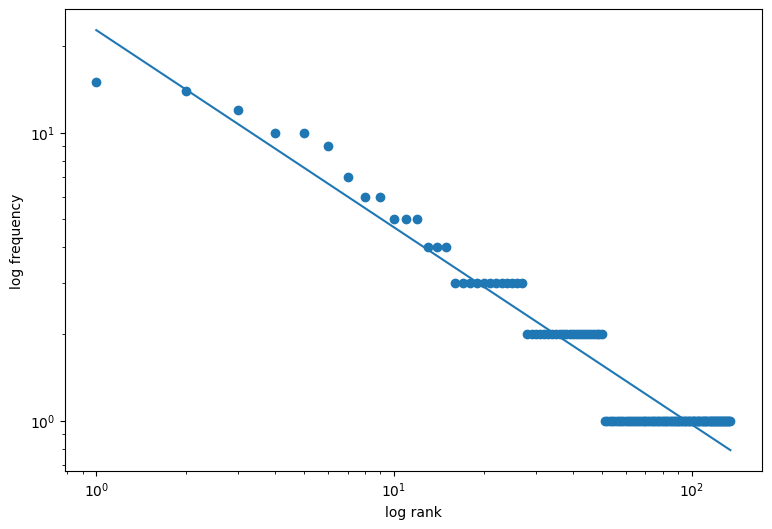

In [78]:
x = np.array([int(i) for i in final_freq_dict.keys()]) # frequency rank as x axis
y = np.array([int(i) for i in final_freq_dict.values()]) # frequency percentage as y axis

fig, ax = plt.subplots(figsize = (9, 6))

# change scale to log-log
ax.set_yscale("log")
ax.set_xscale("log")

#set x and y labels
plt.xlabel('log rank')
plt.ylabel('log frequency')

#add plot scatter plot
ax.scatter(x, y)

# calcuate best fit line on a log-log scale (referenced from Craig [2017])
slope, intercept = np.polyfit(np.log(x), np.log(y), 1) # fit log(y) = m*log(x) + c
y_fit = np.exp(slope * np.log(x) + intercept) # calculate the fitted values of y 
ax.plot(x, y_fit)

plt.show()

In order to calcuate the difference between the text' Zipfian Difference, we will use the absolute difference in the gradient between the plotted line, and the Zipf's law line (which has a gradient of -1 on a log-log scale)

In [79]:
print(f'The line gradient is: {slope}')
print(f'The difference between the line and Zipf\'s law is {np.absolute(-1 - slope)}')

The line gradient is: -0.6848123376016977
The difference between the line and Zipf's law is 0.3151876623983023


Next, we will gather the above method into a function (minus the line plotting code, as we only need the gradient of the line, and do not need to plot and show the actual graph) called calc_zipfian_diff, so we can call it on each row of the dataframe.

In [80]:
def calc_zipfian_diff(row):
    answer = df_cleaned.at[row, 'lemmatised_answer'] #extract answer
    answer = answer.translate(str.maketrans('', '', string.punctuation)) # strip punctuation
    tokens = word_tokenize(answer) #tokenise answer
    freq_dist = nltk.FreqDist(tokens) # create freqdist
    
    freq_dict = dict([(m, n) for m, n in freq_dist.items()]) # create dictionary from frequecy distribution
    freq_dict = collections.OrderedDict(dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))) # sort the items, and create an ordered dictionary

    cntr = 1 #initialise counter
    final_freq_dict = collections.OrderedDict() #initliase final frequency dict

    for key in freq_dict.keys():
        final_freq_dict[cntr] = freq_dict[key] # add each item to final_freq_dict, and change the key to the frequency rank
        cntr += 1 #increment counter

    x = np.array([int(i) for i in final_freq_dict.keys()]) # frequency rank as x axis
    y = np.array([int(i) for i in final_freq_dict.values()]) # frequency percentage as y axis

    # calcuate best fit line on a log-log scale (referenced from https://stackoverflow.com/questions/43837179/best-fit-line-on-log-log-scales-in-python-2-7)
    slope, intercept = np.polyfit(np.log(x), np.log(y), 1) # fit log(y) = m*log(x) + c


    zipfian_diff = np.absolute(-1 - slope) # get absolute difference between the gradient and Zipf's Law line

    return zipfian_diff

Next, we can call the function on each row to find the Zipfian Difference for each answer.

In [81]:
df_cleaned['zipfian_difference'] = 0 #initalise empty column for zipfian difference

In [82]:
for i in range(0, len(df_cleaned)):
    df_cleaned.at[i, 'zipfian_difference'] = calc_zipfian_diff(i)

In [83]:
df_cleaned.sample(3)

,Unnamed: 0.1,Unnamed: 0,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,char_count,...,avg_word_len,polarity,negativity,neutrality,subjectivity,lexical_density,NE_count,coref_count,avg_coref_len,zipfian_difference
35174,35174,35174,Why are circles exactly 360 degrees ? Why are ...,Circles are 360 degrees because that's just ho...,0,Circles 360 degree 's 's always done ! People ...,Circles are 360 degree because that 's just ho...,204,8,908,...,4.450980,0.523800,0.000,0.816,0.371667,0.465686,4,5,3.000,0.391630
20792,20792,20792,Why do two negative numbers yield a positive n...,Great question! When we multiply two negative ...,0,Great question ! When multiply two negative nu...,Great question ! When we multiply two negative...,151,7,784,...,5.192053,-0.513620,0.277,0.532,0.400994,0.503311,4,2,6.500,0.351628
41728,41728,41728,Does food sit normally in your stomach in spac...,"In space, food can behave a bit differently th...",0,"In space , food behave bit differently Earth ....","In space , food can behave a bit differently t...",196,7,936,...,4.775510,-0.106007,0.073,0.874,0.521429,0.525510,4,8,3.125,0.359051


##### 2.4.2 Unique Word Count and Stopword Count

We will also extract the unique word proportion and stopword proportion for each text.

We will quantify this by:

1) extracting the proportion of unique words in each answer, divided over the length of the entire answer
2) extracting the proportion of the answer that is made up of stopwords

In [84]:
from nltk import word_tokenize
from nltk.corpus import stopwords

In [88]:
df_cleaned['unique_word_proportion'] = 0
df_cleaned['stopword_proportion'] = 0

In [89]:
for i in range(0, len(df_cleaned)):
    answer = df_cleaned.at[i, 'answer'] #retrieve answer from df
    word_count = df_cleaned.at[i, 'word_count'] #extract word count from df

    tokens = word_tokenize(answer) # tokenise answer
    
    unique_word_count = len(set(tokens)) # get number of unique words 

    tokens_no_stopwords = [token for token in tokens if token not in stopwords] # create a list of tokens without stopwords
    stopword_count = word_count - len(tokens_no_stopwords) # calculate number of stopwords

    df_cleaned.at[i, 'unique_word_proportion'] = (unique_word_count/word_count) #calcuate unique word proportion
    df_cleaned.at[i, 'stopword_proportion'] = (stopword_count/word_count) # calculate stopword proportion

In [90]:
df_cleaned.sample(3)

,Unnamed: 0.1,Unnamed: 0,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,char_count,...,negativity,neutrality,subjectivity,lexical_density,NE_count,coref_count,avg_coref_len,zipfian_difference,unique_word_proportion,stopword_proportion
37284,37284,37284,Why are there no drugs that make us dramatical...,"There 's a million ways to break a car , rangi...",1,"There 's million way break car , ranging baseb...","There 's a million way to break a car , rangin...",440,15,2388,...,0.054,0.687,0.444821,0.572727,4,5,2.8,0.439770,0.538636,0.300000
12540,12540,12540,Why are imported chinese products of such low ...,Because you usually do n't know its from China...,1,Because usually n't know China high quality . ...,Because you usually do n't know it from China ...,149,9,762,...,0.027,0.856,0.383846,0.489933,4,5,2.6,0.476817,0.597315,0.409396
15387,15387,15387,Can I get my property taxes lowered?,It is possible to get your property taxes lowe...,0,"It possible get property tax lowered , process...",It is possible to get your property tax lowere...,384,12,2088,...,0.081,0.752,0.344700,0.565104,4,5,2.2,0.260105,0.424479,0.429688


We will save this to an intermediate csv file

In [109]:
df_cleaned.to_csv('intermediate_data_3.csv', mode='w')

##### 2.5 Complex Phrase Features

We will also be extracting the count of 2 different types of complex phrases - Ancient phrases and Cliches. 

This will be done by comparing the answer to reference lists of each type of phrase, which have been compiled and cleaned from 2 online sources.

First, we will import the required modules and read in the intermediate csv from the last step

In [2]:
import pandas as pd
import csv

In [3]:
df_cleaned = pd.read_csv('intermediate_data_3.csv')
df_cleaned.sample(3)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,...,negativity,neutrality,subjectivity,lexical_density,NE_count,coref_count,avg_coref_len,zipfian_difference,unique_word_proportion,stopword_proportion
8512,8512,8512,8512,how much does a gold bar weigh,The standard gold bar held as gold reserves by...,1,The standard gold bar held gold reserve centra...,The standard gold bar held a gold reserve by c...,57,1,...,0.000,0.917,0.295833,0.614035,4,0,0.000000,0.666493,0.807018,0.333333
34724,34724,34724,34724,Why certain prescriptions take so long to fill...,There are a few reasons why some prescriptions...,0,There reason prescription may take longer fill...,There are a few reason why some prescription m...,219,5,...,0.074,0.872,0.525952,0.506849,4,9,2.333333,0.386939,0.538813,0.447489
10594,10594,10594,10594,"What are the tiny worm like thing on my neck, ...",This content may violate our content policy. I...,0,This content may violate content policy . If b...,This content may violate our content policy . ...,261,10,...,0.170,0.600,0.601754,0.513410,4,3,4.333333,0.408308,0.544061,0.440613


Next, read in the 2 reference lists from their respective csv files into python lists.

First, we will define a function to convert a csv file to a list

In [4]:
def csv_to_list(filepath):
    # open csv file
    with open(filepath, 'r') as file:
        reader = csv.reader(file) # read csv file
        data = []
        for row in reader:
            data.append(row[0]) # append each row to data list
    return data

and call it on the two reference csv files.

In [5]:
cliches = csv_to_list('phrases/cliches.csv')
ancient_phrases = csv_to_list('phrases/ancient_phrases.csv')
print(cliches)
print(ancient_phrases)

['ace in the hole', 'ace up your sleeve', 'acid test', 'airing dirty laundry', "all in a day's work", 'all talk', 'all booster', 'all hat', 'all foam', 'all hammer', 'all icing', 'all lime and salt', 'all missile', 'all shot', 'all sizzle', 'all wax and no wick', 'all that and a bag of chips', 'all thumbs', 'all wet', "all's fair in love and war", 'almighty dollar', 'always a bridesmaid', 'ambulance chaser', 'another day', 'ants in your pants', 'apple-pie order', 'arm and a leg', 'armchair quarterback', 'army brat', 'art imitates life', 'artsy-craftsy', 'artsy-fartsy', 'as luck would have it', 'as old as time', 'at loggerheads', 'calm before the storm', 'candle at both ends', "can't cut the mustard", 'case of mistaken identity', 'cat out of the bag', 'cat got your tongue', 'caught red-handed', 'chapter and verse', 'checkered career', 'chickens come home to', 'roost', 'chomping at the bit', 'cleanliness is next to', 'godliness', 'clear as a bell', 'clear as mud', 'cold shoulder', 'E-tic

Next, we will also need to lemmatise all the phrases in each phrase list for comparison (as the answers will also be lemmatised)

First, we will define a function to lemmatise all phrases in a phrase list and call it on the phrase lists

In [6]:
def lemmatise_phrase_list(phrase_list):
    output_list = []
    lemmatizer = WordNetLemmatizer()
    for phrase in phrase_list:
        tokens = word_tokenize(phrase)
        lemmatised_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        output_list.append(' '.join(lemmatised_tokens))
        
    return output_list

In [7]:
cliches_lemmatised = lemmatise_phrase_list(cliches)
ancient_lemmatised = lemmatise_phrase_list(ancient_phrases)

print(cliches_lemmatised)
print(ancient_lemmatised)

['ace in the hole', 'ace up your sleeve', 'acid test', 'airing dirty laundry', "all in a day 's work", 'all talk', 'all booster', 'all hat', 'all foam', 'all hammer', 'all icing', 'all lime and salt', 'all missile', 'all shot', 'all sizzle', 'all wax and no wick', 'all that and a bag of chip', 'all thumb', 'all wet', "all 's fair in love and war", 'almighty dollar', 'always a bridesmaid', 'ambulance chaser', 'another day', 'ant in your pant', 'apple-pie order', 'arm and a leg', 'armchair quarterback', 'army brat', 'art imitates life', 'artsy-craftsy', 'artsy-fartsy', 'a luck would have it', 'a old a time', 'at loggerhead', 'calm before the storm', 'candle at both end', "ca n't cut the mustard", 'case of mistaken identity', 'cat out of the bag', 'cat got your tongue', 'caught red-handed', 'chapter and verse', 'checkered career', 'chicken come home to', 'roost', 'chomping at the bit', 'cleanliness is next to', 'godliness', 'clear a a bell', 'clear a mud', 'cold shoulder', 'E-ticket', 'ea

We will also convert all strings to lowercase to ensure that the matching is executed properly

In [8]:
cliches_lemmatised= [cliche.lower() for cliche in cliches_lemmatised]
ancient_lemmatised = [phrase.lower() for phrase in ancient_lemmatised]

print(cliches_lemmatised)
print(ancient_lemmatised)

['ace in the hole', 'ace up your sleeve', 'acid test', 'airing dirty laundry', "all in a day 's work", 'all talk', 'all booster', 'all hat', 'all foam', 'all hammer', 'all icing', 'all lime and salt', 'all missile', 'all shot', 'all sizzle', 'all wax and no wick', 'all that and a bag of chip', 'all thumb', 'all wet', "all 's fair in love and war", 'almighty dollar', 'always a bridesmaid', 'ambulance chaser', 'another day', 'ant in your pant', 'apple-pie order', 'arm and a leg', 'armchair quarterback', 'army brat', 'art imitates life', 'artsy-craftsy', 'artsy-fartsy', 'a luck would have it', 'a old a time', 'at loggerhead', 'calm before the storm', 'candle at both end', "ca n't cut the mustard", 'case of mistaken identity', 'cat out of the bag', 'cat got your tongue', 'caught red-handed', 'chapter and verse', 'checkered career', 'chicken come home to', 'roost', 'chomping at the bit', 'cleanliness is next to', 'godliness', 'clear a a bell', 'clear a mud', 'cold shoulder', 'e-ticket', 'ea

Finally, we will carry out the matching on each answer

In [9]:
#initialise empty columns for the features
df_cleaned['cliche_count'] = 0 
df_cleaned['ancient_phrase_count'] = 0

In [10]:
for i in range(0, len(df_cleaned)):
    answer = df_cleaned.at[i, 'answer'] #retrieve answer from df
    answer = answer.lower() # convert the answer to all lower case

    cliche_cntr = 0
    for cliche in cliches:
        if cliche in answer:
            cliche_cntr += 1
    
    ancient_phrase_cntr = 0
    for phrase in ancient_phrases:
        if phrase in answer:
            ancient_phrase_cntr += 1
    
    df_cleaned.at[i, 'cliche_count'] = cliche_cntr
    df_cleaned.at[i, 'ancient_phrase_count'] = ancient_phrase_cntr

In [11]:
df_cleaned.sample(3)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,...,subjectivity,lexical_density,NE_count,coref_count,avg_coref_len,zipfian_difference,unique_word_proportion,stopword_proportion,cliche_count,ancient_phrase_count
9377,9377,9377,9377,Is my son having asbugers?what are the symptom...,It is important to note that it is not appropr...,0,It important note appropriate diagnose individ...,It is important to note that it is not appropr...,180,5,...,0.433712,0.511111,4,6,2.666667,0.425451,0.550000,0.438889,0,7
31003,31003,31003,31003,What causes tiredness and breathlessness after...,Hi thanks for contacting HCM.....Pleuricy mean...,1,Hi thanks contacting HCM ..... Pleuricy mean i...,Hi thanks for contacting HCM ..... Pleuricy me...,95,4,...,0.462500,0.726316,4,2,2.000000,0.806178,0.831579,0.210526,0,9
14654,14654,14654,14654,How much does taking a Microeconomics course h...,A microeconomics course can help you understan...,0,A microeconomics course help understand fundam...,A microeconomics course can help you understan...,126,5,...,0.423333,0.603175,4,2,2.000000,0.526173,0.611111,0.325397,0,12


We will also save the final dataframe with all extracted features to a csv file

In [12]:
df_cleaned.to_csv('final_feature_data.csv')

### 3. Classification

As we discovered in Prototype 2, the Random Forest Classifier (RFC) trained using a combination of all 5 featuresets was the highest-performing algorithm.

Thus, we will be training and using an RFC using all 5 featuresets in this final prototype.

First, install scikit-learn and import the neccessary packages and load the csv file of extracted features

In [13]:
#!pip install scikit-learn

In [14]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
df = pd.read_csv('final_feature_data.csv')
df.sample(3)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,...,subjectivity,lexical_density,NE_count,coref_count,avg_coref_len,zipfian_difference,unique_word_proportion,stopword_proportion,cliche_count,ancient_phrase_count
14750,14750,14750,14750,14750,Where do old blood cells go in our body when t...,Old or damaged red blood cells are removed fro...,0,Old damaged red blood cell removed circulation...,Old or damaged red blood cell are removed from...,149,...,0.317532,0.604027,4,6,3.000000,0.371419,0.510067,0.395973,0,6
30416,30416,30416,30416,30416,Why do I automatically assume everyone I am ta...,"This is a result of a "" male as a normative "" ...",1,"This result `` male normative `` theme , summe...",This is a result of a `` male a a normative ``...,236,...,0.161765,0.512712,4,5,2.200000,0.530847,0.580508,0.326271,0,7
1659,1659,1659,1659,1659,what did isaac newton do,"Isaac Newton was an English physicist, mathema...",0,"Isaac Newton English physicist , mathematician...","Isaac Newton wa an English physicist , mathema...",740,...,0.420501,0.617568,4,9,5.444444,0.092804,0.267568,0.402703,0,15


We will also drop some of the unused index columns that were created previously when saving the intermediate feature data to csv file

In [16]:
df.drop(df.columns[0:4], axis=1, inplace=True)

In [17]:
df.sample(3)

,question,answer,is_human,filtered_answer,lemmatised_answer,word_count,sentence_count,char_count,avg_sentence_len,avg_word_len,...,subjectivity,lexical_density,NE_count,coref_count,avg_coref_len,zipfian_difference,unique_word_proportion,stopword_proportion,cliche_count,ancient_phrase_count
20847,Who is the husband of Betty Ford,"Betty Ford was the wife of Gerald Ford, who wa...",0,"Betty Ford wife Gerald Ford , President United...","Betty Ford wa the wife of Gerald Ford , who wa...",260,12,1320,21.666667,5.076923,...,0.324150,0.607692,4,11,4.454545,0.171170,0.342308,0.338462,0,9
40269,how does a candle burn so long ? Like it 's ju...,\A candle burns because the heat of the flame ...,0,\A candle burn heat flame melt wax near wick ....,\A candle burn because the heat of the flame m...,197,7,889,28.142857,4.512690,...,0.500000,0.558376,4,6,4.833333,0.175424,0.350254,0.451777,0,3
28109,Why diesel engine can not run on petrol ? And ...,Diesel engines and gasoline engines are design...,0,Diesel engine gasoline engine designed run dif...,Diesel engine and gasoline engine are designed...,289,7,1518,41.285714,5.252595,...,0.567667,0.615917,4,8,2.250000,0.172328,0.290657,0.391003,0,6


Next, we will Split the dataset into independent variables (x) and the dependent (target) variable (y)

In [18]:
# split into target and independent variables

# select all columns except for the specified ones
x = df.loc[:, ~df.columns.isin(['question', 'answer', 'is_human', 'filtered_answer', 'lemmatised_answer'])]

#select is_human as target
y = df['is_human'] # target

In [19]:
x.sample(3)

,word_count,sentence_count,char_count,avg_sentence_len,avg_word_len,polarity,negativity,neutrality,subjectivity,lexical_density,NE_count,coref_count,avg_coref_len,zipfian_difference,unique_word_proportion,stopword_proportion,cliche_count,ancient_phrase_count
7290,179,8,893,22.375000,4.988827,-0.335965,0.052,0.924,0.577778,0.519553,4,3,2.0,0.475852,0.603352,0.407821,0,6
40449,140,9,705,15.555556,5.035714,0.254215,0.101,0.736,0.536554,0.557143,4,5,2.6,0.596449,0.678571,0.357143,1,9
31166,337,10,1754,33.700000,5.204748,0.593119,0.074,0.662,0.489423,0.513353,4,7,7.0,0.230984,0.394659,0.430267,0,10


Additionally, we will also scale the x values using sci-kit's StandardScaler. This scales each x value so that they have the same scale and dimension, which prevents differently-scaled variables from introducting biases into the modelling.

In [20]:
# initialise scaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

Next, split the data into testing (20%) and training (80%) sets using sklearn's train_test_split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 42)

Initialise the RFC, and fit it on the test data.

In [22]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train) # train RFC

RandomForestClassifier()

Next, generate a prediction using the RFC

In [23]:
# generate prediction
rfc_predict = rfc.predict(x_test)

Also, we will generate the RFC's predicted probability of each class prediction for evaluation using sklearn's predict_proba method.

In [24]:
rfc_proba = rfc.predict_proba(x_test)
rfc_proba = rfc_proba[:, 1] # keep only the probability of the positive class

### 4. Evaluation

The next step will be to evaluate the performance of the RFC


First, we will import the required modules

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

Next, we will define some helper functions that will be used to plot confusion matrices, calculate EER, calculate performance stats, and add numerical labels to bar charts.

In [26]:
# plots a confusion matrix display
def plot_con_matrix(y_test, y_predict):
    # create confusion matrix
    con_matrix = confusion_matrix(y_test, y_predict)
    # create confusion matrix display and set labels
    cm_display = ConfusionMatrixDisplay(con_matrix, display_labels=['gpt', 'human'])
    # plot and show confusion matrix
    return cm_display

# calculates FPR and TPR
def calc_fpr_tpr(y_test, y_predict):

    # create confusion matrix
    con_matrix = confusion_matrix(y_test, y_predict)
    false_pos_rate = con_matrix[0][1] / (con_matrix[0][0] + con_matrix[0][1]) #calculate fpr
    true_pos_rate = con_matrix[1][1] / (con_matrix[1][0] + con_matrix[1][1]) #calculate tpr

    return false_pos_rate, true_pos_rate

# calculates EER
# method referenced from James S. [2017].
def calc_eer(y_test, y_prob):
    # generate roc curve, and fpr, tpr lists and the threshold
    fpr, tpr, threshold = roc_curve(y_test, y_prob, pos_label = 1)
    # compute false negative rate
    fnr = 1 - tpr
    # find EER 
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

    return eer

# calculates accuracy, roc, eer, precision, recall
def calc_performance_stats(y_test, y_predict, y_prob):
    accuracy = accuracy_score(y_test, y_predict) # calculate accuracy
    roc_score = roc_auc_score(y_test, y_predict) # calculate ROC
    eer = calc_eer(y_test, y_prob) # calculate EER
    precision = precision_score(y_test, y_predict) # calculate precision
    recall = recall_score(y_test, y_predict) # calculate recall

    return accuracy, roc_score, eer, precision, recall

# add value labels to bar charts
def add_val_labels(x, y, ax):
    for i in range(len(x)):
        ax.text(x[i], y[i]/3, f'{y[i]:.3f}', ha = 'center') # draw value at 30% height of each bar

##### 4.1 Model Evaluation

First, to get a brief visual overview of each model's performance, we will plot its confusion matrix and ROC curve.

First, we will plot the confusion matrix for each model.

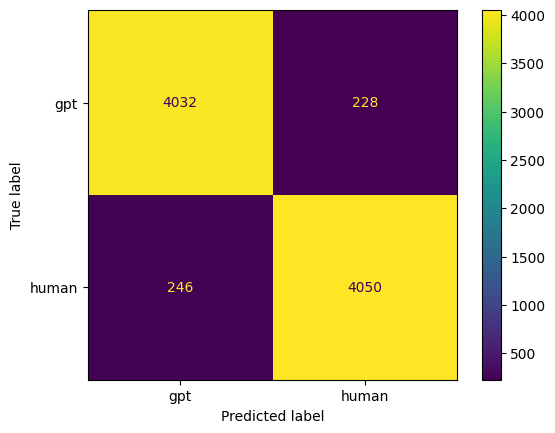

In [27]:
plot_con_matrix(y_test, rfc_predict).plot()

A brief look at the RFC's confusion matrix shows that it performs at a high level, with a high proportion of correctly identified human/GPT answers.

Next, we will plot its ROC curve.

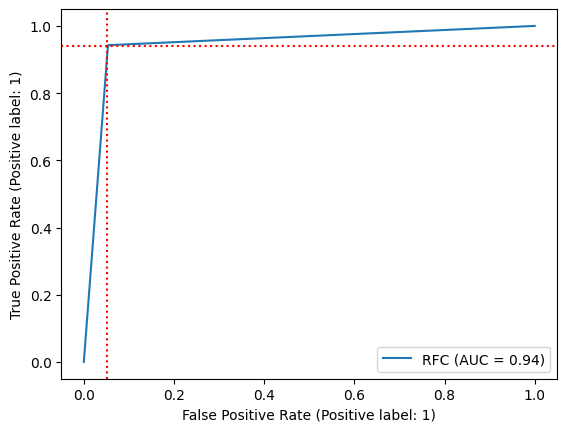

In [28]:
RocCurveDisplay.from_predictions(y_test, rfc_predict, name = 'RFC')
plt.axvline(0.051, color = 'r', linestyle = ':')
plt.axhline(0.94, color = 'r', linestyle = ':')

Once again, this shows that the RFC performs well (at 0.95 AUC). 

The curve also shows an inflection point at about 0.051 (Red dotted line) False positive rate (FPR), where the model's True positive rate (TPR) does not improve significantly beyond that point. 


This raises the possibility of limiting the false positive rate to about 0.051 in instances where false positives are of critical importance (e.g., usage in examination systems). One possible way of achieving this would be using probabilistic classification instead of binary classification. Using the probability weights, along with a set of user-defined scoring rules, could help keep the FPR low, while still maintaining 99% (~0.94 TPR) of the model's performance.

Next, we will calculate the RFC's:

1) Accuracy
2) AUROC Score
3) Equal Error Rate (EER)
4) Precision
5) Recall

In [29]:
# calculate acc, roc, eer, precision, recall
rfc_acc, rfc_roc, rfc_eer, rfc_precision, rfc_recall = calc_performance_stats(y_test, rfc_predict, rfc_proba)

# print out stats
print(f'Accuracy: {rfc_acc}, ROC: {rfc_roc}, EER: {rfc_eer}, Precision: {rfc_precision}, Recall: {rfc_recall}')

Accuracy: 0.9446002805049089, ROC: 0.9446081517035171, EER: 0.05516431924882629, Precision: 0.9467040673211781, Recall: 0.9427374301675978


We will also compare the performance of the RFC against our feature prototype, and results from other literature.

First, we will construct lists of the stats, as well as some labels and colours.

In [30]:
# assemble list of stats
accuracies =  [rfc_acc, 0.92727, 0.786, 0.98]
rocs = [rfc_roc, 0.92715, 0.862, 0]
eers = [rfc_eer, 0.07317, 0, 0.029]


# also assemble list of labels and colours
labels = ['RFC', 'Feature Prototype', 'Frohling & Zubiaga', 'Nguyen-Son et al.']
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']

Finally, we will plot the bar charts (Metrics that are not available in other literature are set to 0)

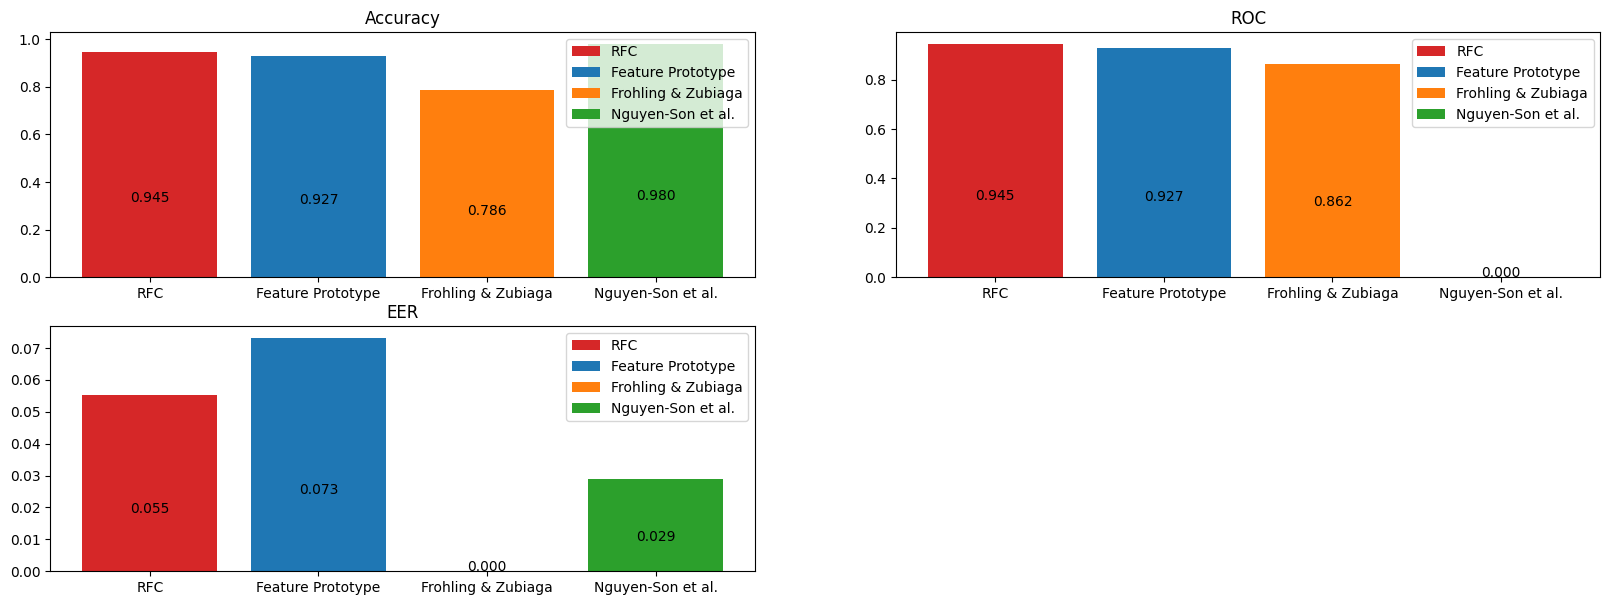

In [31]:
fig, axes = plt.subplots(2, 2, figsize = (20, 7))

axes[0][0].set_title('Accuracy') # set plot title
axes[0][0].bar(labels, accuracies, label = labels, color = colors) # plot barplot
axes[0][0].legend() # add legend
add_val_labels(labels, accuracies, axes[0][0]) # add value labels

axes[0][1].set_title('ROC')
axes[0][1].bar(labels, rocs, label = labels, color = colors)
axes[0][1].legend()
add_val_labels(labels, rocs, axes[0][1])

axes[1][0].set_title('EER')
axes[1][0].bar(labels, eers, label = labels, color = colors)
axes[1][0].legend()
add_val_labels(labels, eers, axes[1][0])

fig.delaxes(axes[1][1]) # remove last empty plot

As expected, our RFC has achieved improved performance from the feature prototype, with improved accuracy, FPR, ROC, and EER.

Additionally, we would consider our RFC to have achieved mostly competitive performance against the models in other literature. It has achieved better accuracy and AUROC compared to Fröhling and Zubiaga [2021]'s best model. Its accuracy is also comparable to the model in Nguyen-Son et al. [2017], though its EER remains significantly higher.

We will also calculate the RFC's FPR and TPR, and visualise it against the performance of the feature prototype.

In [32]:
rfc_fpr, rfc_tpr = calc_fpr_tpr(y_test, rfc_predict)
print(f'RFC - FPR: {rfc_fpr}, TPR: {rfc_tpr}')

RFC - FPR: 0.05352112676056338, TPR: 0.9427374301675978


In [33]:
fprs = [rfc_fpr, 0.09350]
tprs = [rfc_tpr, 0.94779]

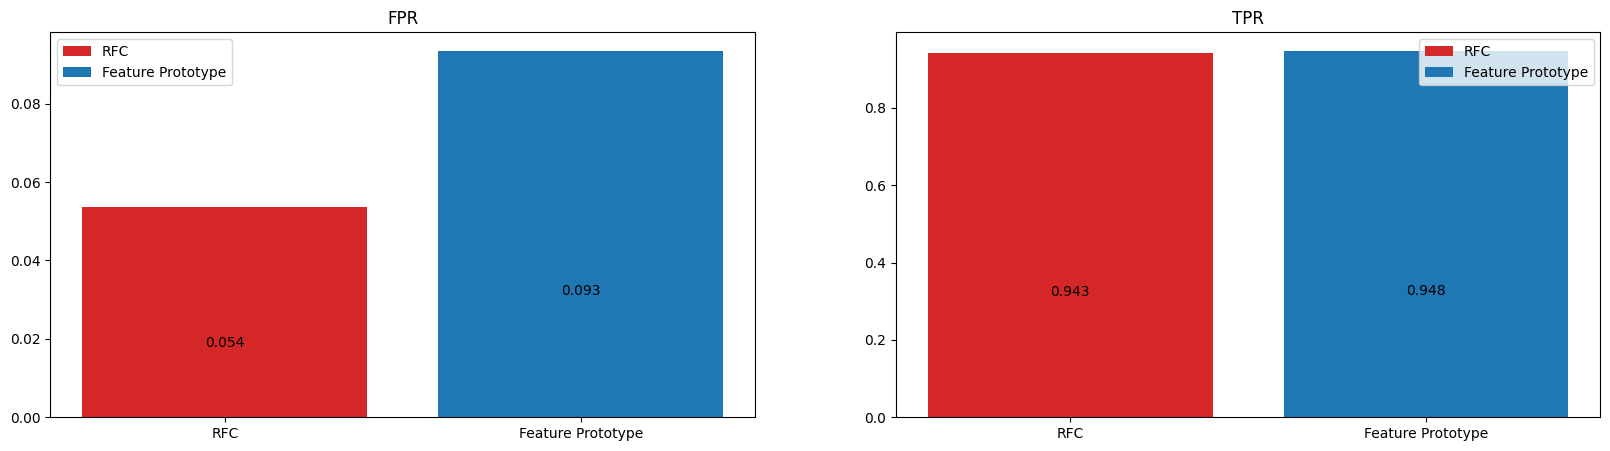

In [34]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))

axes[0].set_title('FPR') # set plot title
axes[0].bar(labels[0:2], fprs, label = labels[0:2], color = colors) # plot barplot
axes[0].legend() # add legend
add_val_labels(labels[0:2], fprs, axes[0]) # add value labels

axes[1].set_title('TPR')
axes[1].bar(labels[0:2], tprs, label = labels[0:2], color = colors)
axes[1].legend()
add_val_labels(labels[0:2], tprs, axes[1])

These bar graphs show that the RFC has significantly improved the FPR, which was a point of concern regarding the Feature Prototype's performance.

#### 5. Conclusions

From the testing and evaluation carried out above, we would conclude that our RFC model has achieved the stated goals of:

1) Performed better than the baseline of human performance (better than random chance (RFC accuracy is >50%))
2) Having competitive/better performance with results from established literature.

Thus, we would consider the stated aims for this project to be achieved, and the project to be complete.

#### 6. Future Work

Our model's EER still remains higher than the model in Nguyen-Son et al. [2017]. In this vein, we would consider the earlier possibility of experimenting with probabilistic classification and scoring regimes to be a possible area where the model's FPR (and thus EER) can be improved.

Another possibility we would like to explore in the future is using implementing an ensemble classifier, such as the ones found in Fröhling and Zubiaga [2021]. These ensemble classifiers combine multiple classification algorithms to achieve better performance, and is an area we would like to explore further. However, one risk of using ensemble classifiers is that adding poorer performing classifiers may also 'dilute' the better performing ones, damaging performance. 


#### 7. References
[1] Lavanya Reddy. 2019. Answer to “AttributeError: probability estimates are not available for loss=’hinge’.” Stack Overflow. Retrieved June 28, 2023 from https://stackoverflow.com/a/57789235

[2] Craig. 2017. Answer to “Best Fit Line on Log Log Scales in python 2.7.” Stack Overflow. Retrieved August 18, 2023 from https://stackoverflow.com/a/43838500

[3] James S. 2017. Answer to “Equal Error Rate in Python.” Stack Overflow. Retrieved June 7, 2023 from https://stackoverflow.com/a/46026962

[4] Leon Fröhling and Arkaitz Zubiaga. 2021. Feature-based detection of automated language models: tackling GPT-2, GPT-3 and Grover. PeerJ Comput Sci 7, (April 2021), e443. DOI:https://doi.org/10.7717/peerj-cs.443

[5] Hoang-Quoc Nguyen-Son, Ngoc-Dung T. Tieu, Huy H. Nguyen, Junichi Yamagishi, and Isao Echi Zen. 2017. Identifying computer-generated text using statistical analysis. In 2017 Asia-Pacific Signal and Information Processing Association Annual Summit and Conference (APSIPA ASC), IEEE, Kuala Lumpur, 1504–1511. DOI:https://doi.org/10.1109/APSIPA.2017.8282270